In [1]:
!pip install ta
!pip install fsspec # For Colab
!pip install s3fs # For Colab
!pip install Mlflow

  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=57ae2c705407a970bde583ad0ec79bef5f47e80b8829c519a4df2222848ccd21
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
     |████████████████████████████████| 134 kB 5.5 MB/s 
     |████████████████████████████████| 1.1 MB 7.5 MB/s 
     |████████████████████████████████| 57 kB 4.5 MB/s 
     |████████████████████████████████| 8.4 MB 30.1 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 45.5 MB/s 
     |████████████████████████████████| 144 kB 43.8 MB/s 
     |████████████████████████████████| 138 kB 47.5 MB/s 
  Created wheel for aiobotocore: filename=aiobotocore-2.1.1-py3-none-any.whl size=55483 sha256=d2c4c0a3a44f54e8968a9c774745c73ff12aa5a22bf4cee322b92b447fe1823e
  Stored in directory: /root/.cache/pip/wheels/52/fd/d3/e85dd95a98c12426ed6864dc24a408c3ca3253d4387b2f1cce
Succ

In [100]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
import os
import gc
import traceback
# import datatable as dt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
import s3fs # For Colab
import mlflow
from mlflow.tracking import MlflowClient
from datetime import timedelta

In [3]:
# Set graph style and font
sns.set()
# Change the axes' title and label size to 18 & 16 by default and default figure size, and make title bold
# Axes formatter limit will only display scientific notation if it's > 10^7 (or 10 million JPY) or < 10^-5
plt.rcParams.update({'axes.titleweight': 'bold','figure.figsize': (18,10),'axes.titlesize': 18,'axes.labelsize': 16, 
                     'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'font.family': 'serif', 
                     'axes.formatter.limits':'-5, 7'}) 

# Loading data

In [4]:
# For Kaggle use only
# directory_path = "/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/"
# BTC = pd.read_csv(directory_path + 'btcusd.csv')
# print(BTC.head())
# ETH = pd.read_csv(directory_path + 'ethusd.csv')
# print(ETH.head())
# LTC = pd.read_csv(directory_path + 'ltcusd.csv')
# print(LTC.head())

BTC_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/btcusd.csv"
BTC_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/btcusd.csv"
ETH_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/etcusd.csv"
ETH_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/etcusd.csv"
LTC_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/ltcusd.csv"
LTC_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/ltcusd.csv"

# Loading online from S3
BTC = pd.read_csv(BTC_USD_S3URI)
print(BTC.head())
ETH = pd.read_csv(ETH_USD_URL)
print(ETH.head())
LTC = pd.read_csv(LTC_USD_S3URI)
print(LTC.head())

            time    open   close    high     low     volume
0  1364774820000   93.25   93.30   93.30   93.25  93.300000
1  1364774880000  100.00  100.00  100.00  100.00  93.300000
2  1364774940000   93.30   93.30   93.30   93.30  33.676862
3  1364775060000   93.35   93.47   93.47   93.35  20.000000
4  1364775120000   93.47   93.47   93.47   93.47   2.021627
            time  open  close  high  low  volume
0  1469575200000  2.50    2.5  2.50  2.5    0.01
1  1469575440000  2.50    2.5  2.50  2.5    0.02
2  1469575500000  2.50    2.5  2.50  2.5    0.01
3  1469636160000  2.50    2.5  2.50  2.5    0.06
4  1469636220000  2.23    2.0  2.23  2.0    1.01
            time    open   close    high     low  volume
0  1368976980000  3.1491  3.1491  3.1491  3.1491    10.0
1  1368980160000  3.1491  3.1491  3.1491  3.1491     1.0
2  1368980940000  3.1491  3.1491  3.1491  3.1491     1.0
3  1369223280000  2.9900  2.9900  2.9900  2.9900    15.0
4  1369251120000  3.1300  3.1300  3.1300  3.1300     0.1


In [5]:
# Convert to human timestamp
BTC['time'] = pd.to_datetime(BTC['time'], unit='ms')
ETH['time'] = pd.to_datetime(ETH['time'], unit='ms')
LTC['time'] = pd.to_datetime(LTC['time'], unit='ms')

In [6]:
BTC.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,time,open,close,high,low,volume
count,3750538,3.750538e+06,3.750538e+06,3.750538e+06,3.750538e+06,3.750538e+06
unique,3750538,NaN,NaN,NaN,NaN,NaN
top,2013-04-01 00:07:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
first,2013-04-01 00:07:00,NaN,NaN,NaN,NaN,NaN
last,2022-02-26 10:52:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.175632e+04,1.175634e+04,1.176248e+04,1.175017e+04,1.602312e+01
std,NaN,1.630193e+04,1.630199e+04,1.631052e+04,1.629339e+04,5.593794e+01
min,NaN,1.000000e-02,1.060000e+00,1.060000e+00,1.000000e-02,1.000000e-08
25%,NaN,6.734500e+02,6.734600e+02,6.738800e+02,6.730000e+02,5.093002e-01


In [7]:
ETH.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,time,open,close,high,low,volume
count,1373168,1.373168e+06,1.373168e+06,1.373168e+06,1.373168e+06,1.373168e+06
unique,1373168,NaN,NaN,NaN,NaN,NaN
top,2016-07-26 23:20:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
first,2016-07-26 23:20:00,NaN,NaN,NaN,NaN,NaN
last,2022-02-26 10:51:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.884307e+01,1.884306e+01,1.886032e+01,1.882548e+01,4.889151e+02
std,NaN,1.824731e+01,1.824694e+01,1.826869e+01,1.822502e+01,1.954369e+03
min,NaN,7.200000e-01,7.200000e-01,7.200000e-01,7.200000e-01,1.000000e-08
25%,NaN,6.423400e+00,6.423200e+00,6.427600e+00,6.420000e+00,8.408346e+00


In [8]:
LTC.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,time,open,close,high,low,volume
count,2368282,2.368282e+06,2.368282e+06,2.368282e+06,2.368282e+06,2.368282e+06
unique,2368282,NaN,NaN,NaN,NaN,NaN
top,2013-05-19 15:23:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
first,2013-05-19 15:23:00,NaN,NaN,NaN,NaN,NaN
last,2022-02-26 10:51:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,9.296359e+01,9.296294e+01,9.304127e+01,9.288425e+01,1.466594e+02
std,NaN,7.336767e+01,7.336740e+01,7.345186e+01,7.328225e+01,5.098539e+02
min,NaN,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-08
25%,NaN,4.245600e+01,4.245500e+01,4.247800e+01,4.243500e+01,3.596867e+00


In [9]:
# Make copies of these df before doing further
BTC_copy = BTC.copy()
ETH_copy = ETH.copy()
LTC_copy = LTC.copy()

In [10]:
# Set time as index for plotting
BTC.set_index('time', inplace=True)
ETH.set_index('time', inplace=True)
LTC.set_index('time', inplace=True)
BTC

,open,close,high,low,volume
time,,,,,
2013-04-01 00:07:00,93.250000,93.30,93.30,93.250000,93.300000
2013-04-01 00:08:00,100.000000,100.00,100.00,100.000000,93.300000
2013-04-01 00:09:00,93.300000,93.30,93.30,93.300000,33.676862
2013-04-01 00:11:00,93.350000,93.47,93.47,93.350000,20.000000
2013-04-01 00:12:00,93.470000,93.47,93.47,93.470000,2.021627
...,...,...,...,...,...
2022-02-26 10:48:00,39000.000000,39012.00,39012.00,39000.000000,0.168502
2022-02-26 10:49:00,39008.000000,38976.00,39008.00,38971.410904,1.341707
2022-02-26 10:50:00,38971.755285,39029.00,39029.00,38967.949394,6.989503


# EDA

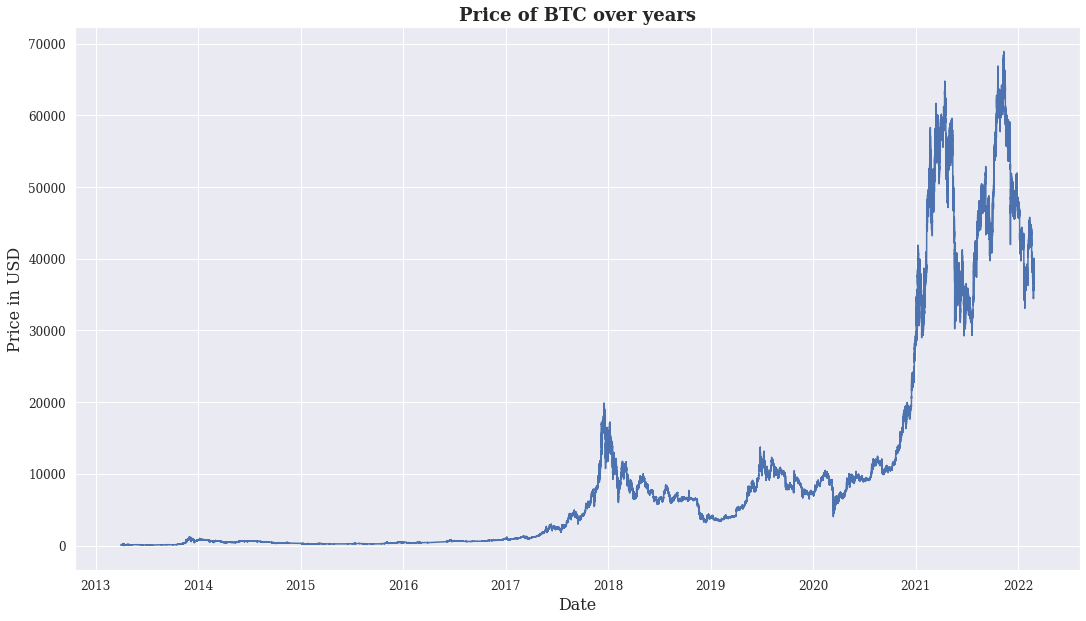

In [11]:
plt.plot(BTC.index, BTC.close)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Price of BTC over years')
plt.show()

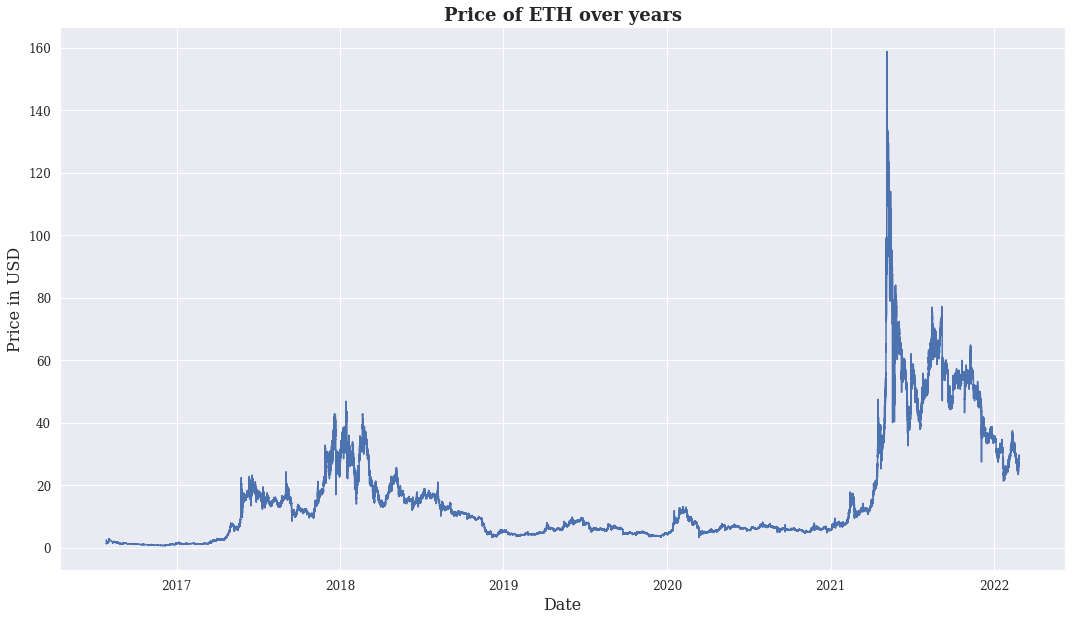

In [12]:
plt.plot(ETH.index, ETH.close)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Price of ETH over years')
plt.show()

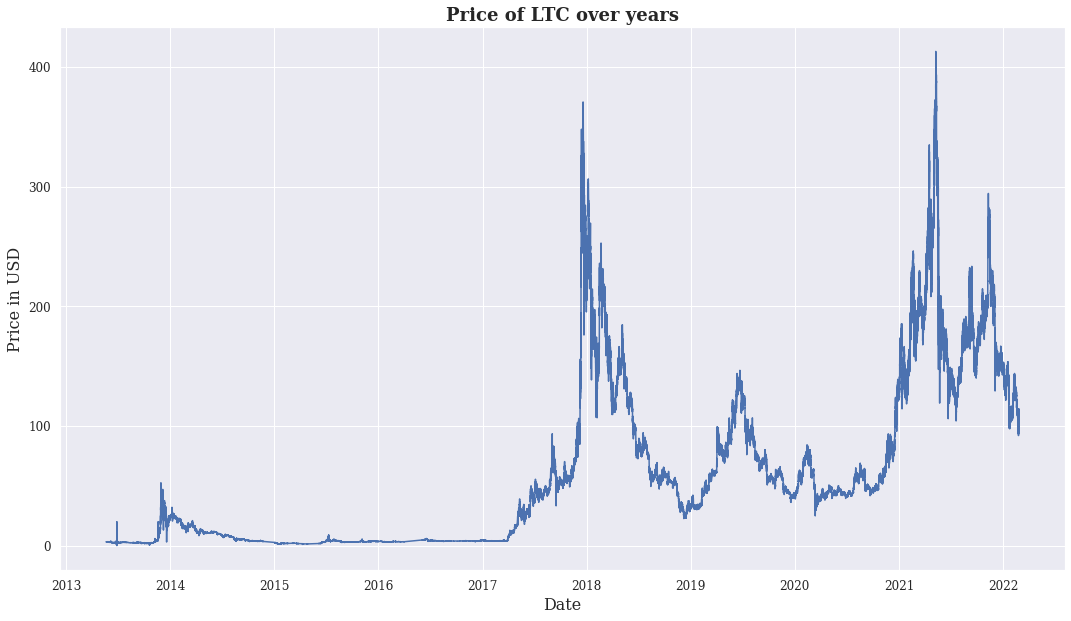

In [13]:
plt.plot(LTC.index, LTC.close)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Price of LTC over years')
plt.show()

In [14]:
print(BTC.isnull().sum())
print(ETH.isnull().sum())
print(LTC.isnull().sum())

open      0
close     0
high      0
low       0
volume    0
dtype: int64
open      0
close     0
high      0
low       0
volume    0
dtype: int64
open      0
close     0
high      0
low       0
volume    0
dtype: int64


No null values at all, no need to drop any data

In [15]:
# Use only data from the last 2 years for modelling
BTC_2yr = BTC['2020-01-01':]
ETH_2yr = ETH['2020-01-01':]
LTC_2yr = LTC['2020-01-01':]
BTC_2yr

,open,close,high,low,volume
time,,,,,
2020-01-01 00:00:00,7208.200000,7200.000000,7208.200000,7200.000000,0.593130
2020-01-01 00:01:00,7200.000000,7200.000000,7200.000000,7200.000000,0.536795
2020-01-01 00:02:00,7200.000000,7200.038592,7200.038592,7200.000000,0.022248
2020-01-01 00:03:00,7200.000000,7200.000000,7200.000000,7200.000000,0.022585
2020-01-01 00:04:00,7200.000000,7199.000000,7200.000000,7199.000000,0.465026
...,...,...,...,...,...
2022-02-26 10:48:00,39000.000000,39012.000000,39012.000000,39000.000000,0.168502
2022-02-26 10:49:00,39008.000000,38976.000000,39008.000000,38971.410904,1.341707
2022-02-26 10:50:00,38971.755285,39029.000000,39029.000000,38967.949394,6.989503


# Feature engineering

In [16]:
def upper_shadow(df): return df['high'] - np.maximum(df['close'], df['open'])
def lower_shadow(df): return np.minimum(df['close'], df['open']) - df['low']

def get_features(df, row = False):
    df_feat = df
    df_feat['spread'] = df_feat['high'] - df_feat['low']
    df_feat['upper_shadow'] = upper_shadow(df_feat)
    df_feat['lower_shadow'] = lower_shadow(df_feat)
    df_feat['close-open'] = df_feat['close'] - df_feat['open']
    df_feat['SMA_7'] = df_feat.iloc[:,1].rolling(window=7).mean()
    df_feat['SMA_14'] = df_feat.iloc[:,1].rolling(window=14).mean()
    df_feat['SMA_21'] = df_feat.iloc[:,1].rolling(window=21).mean()
    # Create the STD_DEV feature for the past 7 days
    df_feat['STD_DEV_7'] = df_feat.iloc[:,1].rolling(window=7).std()
    # Drop the NA rows created by the SMA indicators
    df_feat.dropna(inplace = True)
    return df_feat

In [17]:
BTC_2yr = get_features(BTC_2yr)
BTC_2yr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,open,close,high,low,volume,spread,upper_shadow,lower_shadow,close-open,SMA_7,SMA_14,SMA_21,STD_DEV_7
time,,,,,,,,,,,,,
2020-01-01 00:20:00,7190.276057,7193.400000,7193.400000,7190.200000,8.780002,3.200000,0.0,0.076057,3.123943,7193.553722,7196.663734,7197.182423,3.174209
2020-01-01 00:21:00,7192.229863,7197.100000,7197.100000,7191.500000,8.148889,5.600000,0.0,0.729863,4.870137,7193.810865,7196.878020,7197.044327,3.403854
2020-01-01 00:22:00,7192.700000,7197.675999,7197.675999,7191.900000,7.596915,5.775999,0.0,0.800000,4.975999,7193.936008,7196.868004,7196.933661,3.545233
2020-01-01 00:23:00,7193.000000,7195.200000,7195.200000,7193.000000,3.716319,2.200000,0.0,0.000000,2.200000,7193.850294,7196.403718,7196.703251,3.499615
2020-01-01 00:24:00,7194.700000,7193.600000,7194.700000,7193.600000,0.025000,1.100000,0.0,0.000000,-1.100000,7193.636008,7195.796575,7196.398490,3.455992
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-26 10:48:00,39000.000000,39012.000000,39012.000000,39000.000000,0.168502,12.000000,0.0,0.000000,12.000000,38984.857143,38988.195477,38997.979571,24.504616
2022-02-26 10:49:00,39008.000000,38976.000000,39008.000000,38971.410904,1.341707,36.589096,0.0,4.589096,-32.000000,38990.142857,38983.266905,38998.455762,15.181442
2022-02-26 10:50:00,38971.755285,39029.000000,39029.000000,38967.949394,6.989503,61.050606,0.0,3.805891,57.244715,38999.000000,38983.571429,38998.771462,17.358955


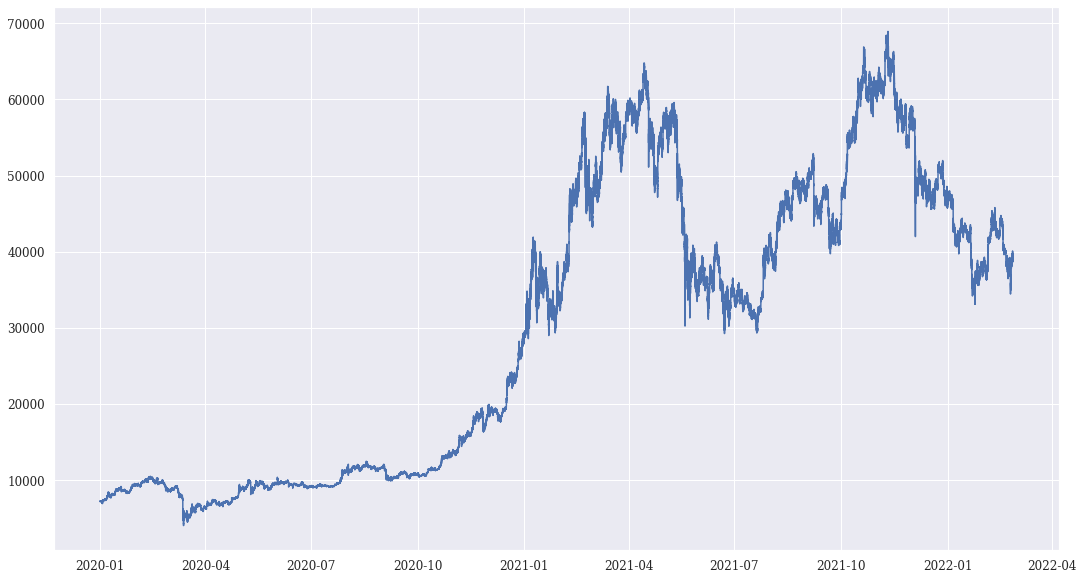

In [18]:
plt.plot(BTC_2yr.index, BTC_2yr['close'])
plt.show()

In [19]:
BTC_y = BTC_2yr['close']
BTC_X = BTC_2yr.drop('close', axis=1)
BTC_X

,open,high,low,volume,spread,upper_shadow,lower_shadow,close-open,SMA_7,SMA_14,SMA_21,STD_DEV_7
time,,,,,,,,,,,,
2020-01-01 00:20:00,7190.276057,7193.400000,7190.200000,8.780002,3.200000,0.0,0.076057,3.123943,7193.553722,7196.663734,7197.182423,3.174209
2020-01-01 00:21:00,7192.229863,7197.100000,7191.500000,8.148889,5.600000,0.0,0.729863,4.870137,7193.810865,7196.878020,7197.044327,3.403854
2020-01-01 00:22:00,7192.700000,7197.675999,7191.900000,7.596915,5.775999,0.0,0.800000,4.975999,7193.936008,7196.868004,7196.933661,3.545233
2020-01-01 00:23:00,7193.000000,7195.200000,7193.000000,3.716319,2.200000,0.0,0.000000,2.200000,7193.850294,7196.403718,7196.703251,3.499615
2020-01-01 00:24:00,7194.700000,7194.700000,7193.600000,0.025000,1.100000,0.0,0.000000,-1.100000,7193.636008,7195.796575,7196.398490,3.455992
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-26 10:48:00,39000.000000,39012.000000,39000.000000,0.168502,12.000000,0.0,0.000000,12.000000,38984.857143,38988.195477,38997.979571,24.504616
2022-02-26 10:49:00,39008.000000,39008.000000,38971.410904,1.341707,36.589096,0.0,4.589096,-32.000000,38990.142857,38983.266905,38998.455762,15.181442
2022-02-26 10:50:00,38971.755285,39029.000000,38967.949394,6.989503,61.050606,0.0,3.805891,57.244715,38999.000000,38983.571429,38998.771462,17.358955


In [20]:
# This way of getting the hourly data is wrong
# BTC_y_hr = BTC_y.resample('h').mean()
# BTC_X_hr = BTC_X.resample('h').mean()
# print(BTC_X_hr.shape, BTC_y_hr.shape)

# For testing

In [21]:
# # Only URL works, S3URI requires credentials
# BTC_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/btcusd.csv"
# BTC_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/btcusd.csv"
# ETH_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/etcusd.csv"
# ETH_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/etcusd.csv"
# LTC_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/ltcusd.csv"
# LTC_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/ltcusd.csv"

# def get_data(crypto, last_rows=500000):
#     """ Get dataset of selected crypto from cloud storage
#     500,000 data points (mins) is roughly equivalent to 1 year worth of data
#     # Params: chosen crypto by the user from the front end """
#     if crypto == "BTC":
#         df_full = pd.read_csv(BTC_USD_URL)
#         n_rows = len(df_full)
#         df = pd.read_csv(BTC_USD_URL, skiprows=range(1, n_rows - last_rows))
#     elif crypto == 'ETH':
#         df_full = pd.read_csv(ETH_USD_URL)
#         n_rows = len(df_full)
#         df = pd.read_csv(ETH_USD_URL, skiprows=range(1, n_rows - last_rows))
#     elif crypto == 'LTC':
#         df_full = pd.read_csv(LTC_USD_URL)
#         n_rows = len(df_full)
#         df = pd.read_csv(LTC_USD_URL, skiprows=range(1, n_rows - last_rows))
#     return df

# def MinMax_fit_transform(X):
#     MinMaxscaler = MinMaxScaler()
#     MinMaxscaler.fit(X)
#     X_transformed = MinMaxscaler.fit_transform(X)
#     return X_transformed, MinMaxscaler

# def MinMax_reverse_fit_transform(MinMaxscaler, X_transformed):
#     X = MinMaxscaler.inverse_transform(X_transformed)
#     return X


# # For testing
# LTC = get_data('LTC')
# print(LTC)
# LTC_transformed, MinMaxscaler = MinMax_fit_transform(LTC)
# print(LTC_transformed)
# LTC_original = MinMax_reverse_fit_transform(MinMaxscaler, LTC_transformed)
# print(LTC_original)

# Utils function

In [22]:
# Memory saving function 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# LSTM model

In [23]:
def daily_data(df,step=1):
    df_sampled = df[['open']].resample(f'{step}D').first()
    df_sampled['close'] = df[['close']].resample(f'{step}D').last()
    df_sampled['high'] = df[[ 'high' ]].resample(f'{step}D').max()
    df_sampled['low']= df[[ 'low' ]].resample(f'{step}D').min()
    df_sampled['volume'] = df[['volume']].resample(f'{step}D').sum()
    df_sampled.interpolate(inplace=True)
    return df_sampled

BTC_day = daily_data(BTC)
BTC_day

,open,close,high,low,volume
time,,,,,
2013-04-01,93.250000,103.999000,105.900000,92.49999,5224.401313
2013-04-02,104.000000,118.229354,118.386700,99.00000,8376.527478
2013-04-03,117.958261,134.700000,146.880000,101.51088,12996.245072
2013-04-04,134.716560,132.899000,143.000000,119.00000,6981.668305
2013-04-05,130.100010,142.300000,145.000000,128.25000,5234.882203
...,...,...,...,...,...
2022-02-22,37078.000000,38299.000000,38485.000000,36402.00000,6204.849429
2022-02-23,38294.000000,37305.000000,39310.000000,37117.00000,5807.624625
2022-02-24,37305.000000,38383.000000,39926.000000,34425.00000,17875.338400


In [24]:
BTC_day.isnull().sum()

open      0
close     0
high      0
low       0
volume    0
dtype: int64

In [25]:
BTC_day_y = BTC_day['close'][14:]  #  Exclude the first 14 days 
# BTC_day_X = BTC_day.drop('close', axis=1)[:-14]  # Exclude the last 14 days
BTC_day_X = BTC_day[:-14]  # Exclude the last 14 days, no need to drop 'close' as it'll be a feature also
print(BTC_day_X.shape, BTC_day_y.shape)

(3240, 5) (3240,)


In [26]:
# 70% for training, 30% for testing
# index_70pct = int(len(BTC_X)*0.7)
# BTC_X_train = BTC_X[:index_70pct]
# BTC_X_test = BTC_X[index_70pct:]
# BTC_y_train = BTC_y[:index_70pct]
# BTC_y_test = BTC_y[index_70pct:]

# # Use simple 70:30 train minutes data
# print(BTC_X_train.shape, BTC_X_test.shape, BTC_y_train.shape, BTC_y_test.shape)

In [27]:
# Reduce memory usage of df's:
BTC_day_X = reduce_mem_usage(BTC_day_X)
# Cannot reduce mem for BTC_day_y as it'll result in error

Memory usage of dataframe is 0.15 MB
Memory usage after optimization is: 0.09 MB
Decreased by 41.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
scaler_X = MinMaxScaler()
BTC_day_X_scaled = scaler_X.fit_transform(BTC_day_X)

scaler_y = MinMaxScaler()
values_BTC_day_y = BTC_day_y.values.reshape(-1, 1)
BTC_day_y_scaled = scaler_y.fit_transform(values_BTC_day_y) 
print(BTC_day_X_scaled.shape, BTC_day_y_scaled.shape)

(3240, 5) (3240, 1)


In [29]:
BTC_day_X_scaled

array([[4.0216499e-04, 5.6150404e-04, 4.7383492e-04, 1.3944758e-03,
        1.9034490e-02],
       [5.6151894e-04, 7.7244954e-04, 6.5510441e-04, 1.4924768e-03,
        3.0518889e-02],
       [7.6843088e-04, 1.0166042e-03, 1.0687418e-03, 1.5303334e-03,
        4.7350287e-02],
       ...,
       [6.5773726e-01, 6.4451462e-01, 6.6525239e-01, 6.5165991e-01,
        2.6700161e-02],
       [6.4457393e-01, 6.2780839e-01, 6.3717651e-01, 6.3338649e-01,
        2.0439900e-02],
       [6.2786770e-01, 6.2522906e-01, 6.2369019e-01, 6.2893879e-01,
        9.7012445e-03]], dtype=float32)

In [31]:
print(np.isnan(BTC_day_X).sum())
print(np.isnan(BTC_day_y).sum())

open      0
close     0
high      0
low       0
volume    0
dtype: int64
0


In [32]:
# Set the index to divide data into train, val, and test sets
index_70pct = int(len(BTC_day_X)*0.7)
index_85pct = int(len(BTC_day_X)*0.85)
print(len(BTC_day_X))
print(index_70pct)
print(index_85pct)

3240
2268
2754


In [33]:
# Define time series generator
seq_len = 30 # Length of each sequence
# window_size = seq_len - 1
# prediction_len = 32
batch_size = 32 # Number of observations
n_features = 5

train_generator = TimeseriesGenerator(BTC_day_X_scaled, BTC_day_y_scaled, length=seq_len, batch_size=batch_size, end_index = index_70pct)
val_generator = TimeseriesGenerator(BTC_day_X_scaled, BTC_day_y_scaled, length=seq_len, batch_size=batch_size, \
                                    start_index = index_70pct, end_index = index_85pct)
test_generator = TimeseriesGenerator(BTC_day_X_scaled, BTC_day_y_scaled, length=seq_len, batch_size=batch_size, start_index = index_85pct)

In [34]:
X_train, y_train = train_generator[0]
print(X_train.shape)
print(y_train.shape)
print(f'Given the Array: \n{X_train.flatten()}')
print(f'Predict this y: \n {y_train}')

X_val , y_val = val_generator[0]
print(X_val.shape)
print(y_val.shape)
print(f'Given the Array: \n{X_val.flatten()}')
print(f'Predict this y: \n {y_val}')

X_test , y_test = test_generator[0]
print(X_test.shape)
print(y_test.shape)
print(f'Given the Array: \n{X_test.flatten()}')
print(f'Predict this y: \n {y_test}')

(32, 30, 5)
(32, 1)
Given the Array: 
[0.00040216 0.0005615  0.00047383 ... 0.00081063 0.00188538 0.00826129]
Predict this y: 
 [[0.0006349 ]
 [0.00072458]
 [0.00076342]
 [0.00077676]
 [0.00077276]
 [0.00077038]
 [0.00075423]
 [0.0007855 ]
 [0.00085547]
 [0.00092766]
 [0.00093166]
 [0.00095049]
 [0.00089134]
 [0.00088023]
 [0.00095212]
 [0.00089802]
 [0.0009158 ]
 [0.0009287 ]
 [0.00085503]
 [0.00084465]
 [0.00080507]
 [0.00081634]
 [0.00078802]
 [0.00066632]
 [0.00063756]
 [0.00050222]
 [0.00056419]
 [0.00061133]
 [0.00060125]
 [0.00053187]
 [0.0004874 ]
 [0.00049363]]
(32, 30, 5)
(32, 1)
Given the Array: 
[0.13222347 0.1376845  0.13670284 ... 0.15235217 0.14740813 0.04696522]
Predict this y: 
 [[0.1485606 ]
 [0.15318557]
 [0.1549644 ]
 [0.15944114]
 [0.1616795 ]
 [0.17429441]
 [0.16907649]
 [0.17688854]
 [0.17764455]
 [0.17528759]
 [0.16669582]
 [0.17046039]
 [0.16806849]
 [0.16065683]
 [0.1482131 ]
 [0.15206291]
 [0.15272604]
 [0.1506359 ]
 [0.15218041]
 [0.16116068]
 [0.15899844]
 

In [35]:
# Best model so far has test MSE = 147201714
# def init_model():
#     model = Sequential()
#     model.add(LSTM(units=128, return_sequences=True, activation='relu', input_shape=(seq_len, n_features)))
#     model.add(LSTM(units=64, activation='tanh'))
#     model.add(Dense(64, activation = 'LeakyReLU'))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation='linear'))
#     return model

# def compile_model(model): 
#     Adam_opt = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
#     model.compile(loss='mse', 
#         optimizer = Adam_opt,
#         metrics='mse')
#     return model

In [114]:
# One model predicts "High" that can act as upper bound
# One model predicts "Low" that can act as lower bound

def init_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, activation='relu', input_shape=(seq_len, n_features)))
    model.add(LSTM(units=64, return_sequences=True, activation='relu'))
    model.add(LSTM(units=32, activation='tanh'))
    model.add(Dense(32, activation = 'LeakyReLU'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='linear'))
    return model

def compile_model(model): 
    Adam_opt = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mse', 
        optimizer = Adam_opt,
        metrics='mae')
    return model

model = init_model()
compile_model(model)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 128)           68608     
                                                                 
 lstm_9 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_10 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 131,521
Trainable params: 131,521
Non-tr

Epoch 1/50
70/70 [==============================] - 20s 221ms/step - loss: 0.0020 - mae: 0.0300 - val_loss: 5.8605e-04 - val_mae: 0.0200
Epoch 2/50
70/70 [==============================] - 19s 273ms/step - loss: 6.6116e-04 - mae: 0.0144 - val_loss: 5.0587e-04 - val_mae: 0.0183
Epoch 3/50
70/70 [==============================] - 13s 193ms/step - loss: 5.2827e-04 - mae: 0.0135 - val_loss: 3.9700e-04 - val_mae: 0.0153
Epoch 4/50
70/70 [==============================] - 14s 194ms/step - loss: 5.3341e-04 - mae: 0.0144 - val_loss: 0.0016 - val_mae: 0.0366
Epoch 5/50
70/70 [==============================] - 14s 199ms/step - loss: 5.0220e-04 - mae: 0.0117 - val_loss: 0.0012 - val_mae: 0.0303
Epoch 6/50
70/70 [==============================] - 14s 193ms/step - loss: 3.5774e-04 - mae: 0.0106 - val_loss: 3.9941e-04 - val_mae: 0.0154
Epoch 7/50
70/70 [==============================] - 14s 195ms/step - loss: 4.8024e-04 - mae: 0.0130 - val_loss: 0.0011 - val_mae: 0.0280
Epoch 8/50
70/70 [===========

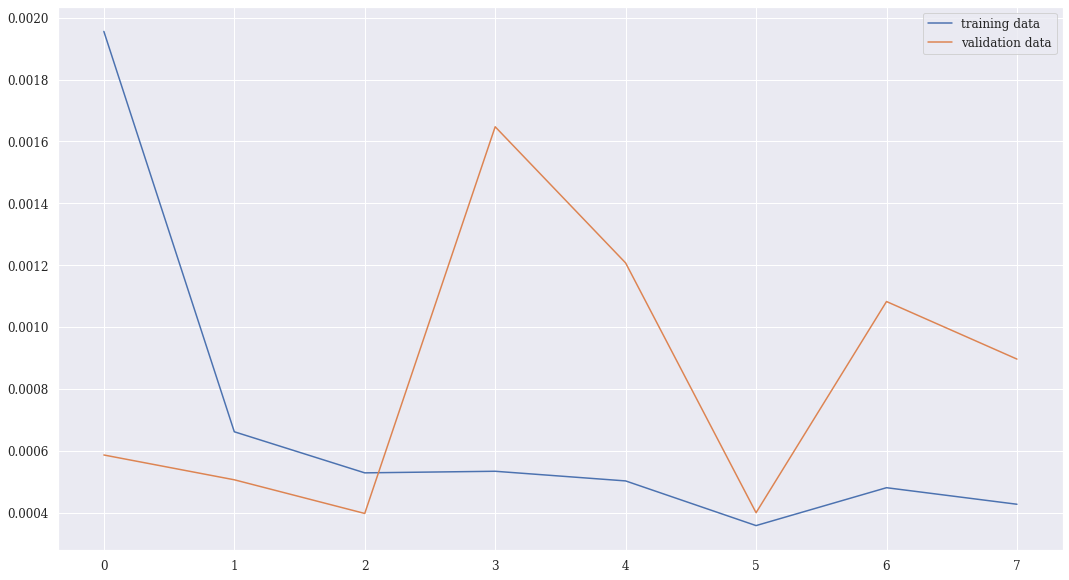

In [115]:
es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
history = model.fit(train_generator, validation_data = val_generator, epochs=50, verbose=1, callbacks=[es])
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.legend()
plt.show()

In [38]:
# Real prices
BTC_day_y

time
2013-04-15       83.302
2013-04-16       67.588
2013-04-17       93.063
2013-04-18      111.300
2013-04-19      119.000
                ...    
2022-02-22    38299.000
2022-02-23    37305.000
2022-02-24    38383.000
2022-02-25    39253.000
2022-02-26    39069.000
Freq: D, Name: close, Length: 3240, dtype: float64

In [40]:
# Only need to run once
EXPERIMENT_NAME = "[Crypto forecasting final] LSTM experiment"
mlflow.set_tracking_uri("https://mlflow.lewagon.co/")

# Only need to run once
client = MlflowClient()
experiment_id = client.create_experiment(EXPERIMENT_NAME)

Actual training data has length (2268,)
Predicted training data has length 2239 (2239, 1)


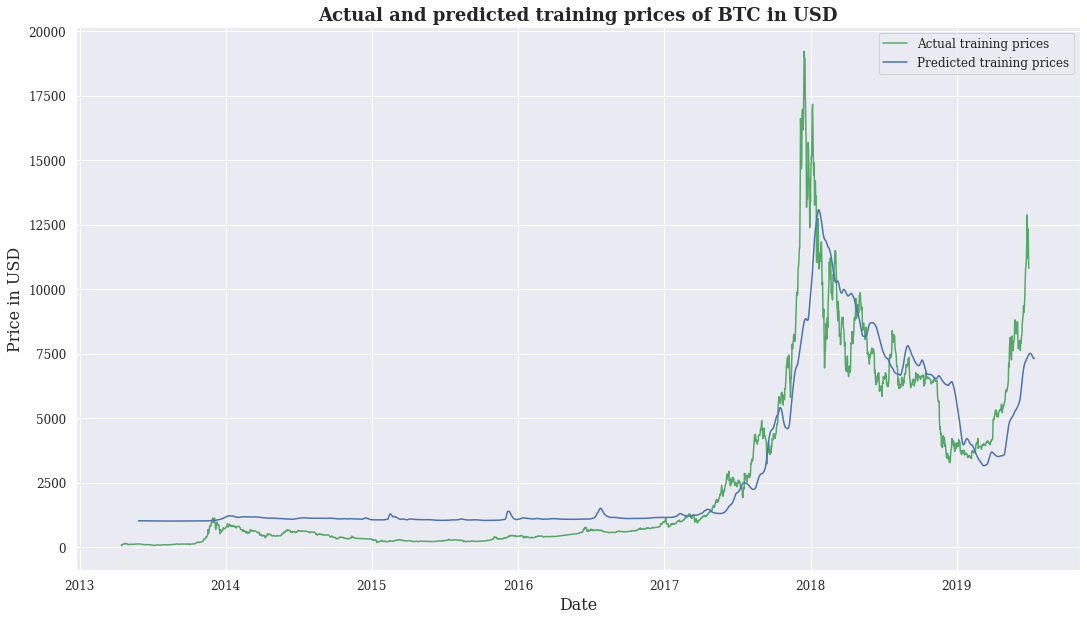

In [116]:
# Predict with training data
BTC_y_pred = model.predict(train_generator)
# print(BTC_y_pred)

# Inverse transform the data back
BTC_y_pred_prices = scaler_y.inverse_transform(BTC_y_pred)
print('Actual training data has length', BTC_day_y[:index_70pct].shape)
print('Predicted training data has length', len(BTC_y_pred_prices), BTC_y_pred_prices.shape)
# print('The MSE is', mean_squared_error(BTC_y_pred_prices, BTC_day_y[13:index_70pct]))

plt.plot(BTC_day_y[:index_70pct].index, BTC_day_y[:index_70pct].values, color = 'g', label = 'Actual training prices')
# Shift index by 30 days forward for predicted prices
plt.plot(BTC_day_y[43:index_70pct+14].index, BTC_y_pred_prices, color = 'b', label = 'Predicted training prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted training prices of BTC in USD')
plt.show()

actual_price            14
date                     0
pred_in_sample_price    44
pred_future_price       30
dtype: int64


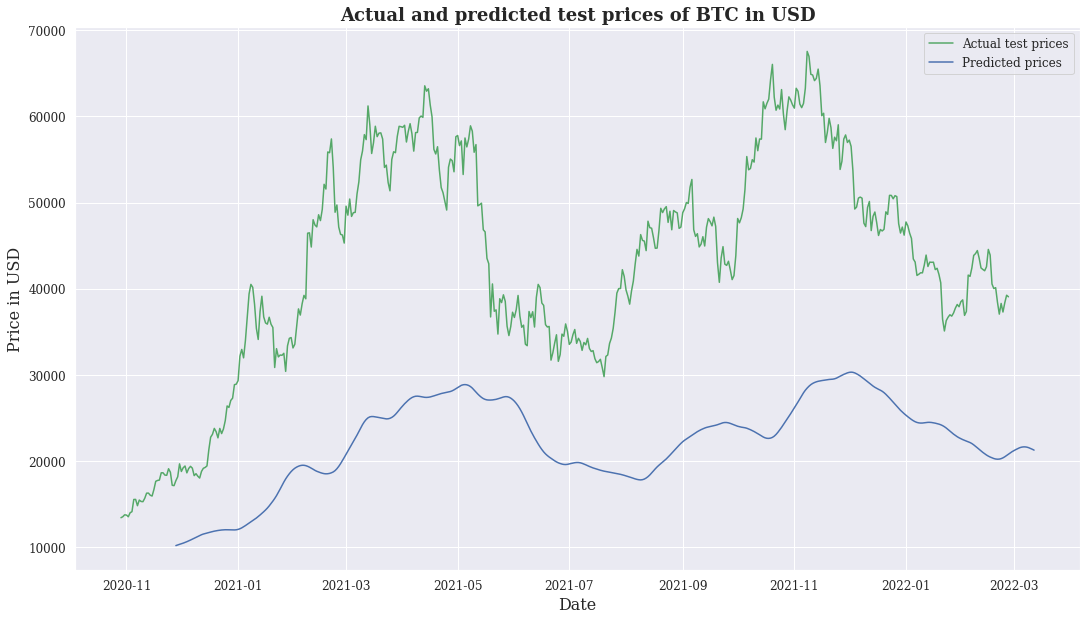

In [117]:
def predict_put_results_in_df_and_plot(model, generator_set):
  # Actual prices from the data
  df_actual = pd.DataFrame({'actual_price':  BTC_day_y[index_85pct:].values, 'date': BTC_day_y[index_85pct:].index})
  
  # Predicted prices from the given generator set
  BTC_y_pred = model.predict(generator_set)
  BTC_y_pred_prices = scaler_y.inverse_transform(BTC_y_pred)
  days_in_sample_pred = BTC_day_y[index_85pct+30:].index
  # print(len(BTC_y_pred_prices), len(days_in_sample_pred))
  df_pred_in_sample = pd.DataFrame({'pred_in_sample_price': BTC_y_pred_prices.reshape(len(BTC_y_pred_prices)), 'date': days_in_sample_pred})

  # Get the extra days for future predicted prices
  days_future_pred = BTC_day_y[-14:].index + timedelta(14)
  # Get the last 30 days of X, and it'll predict close of 14 days later
  scaled_BTC_day = scaler_X.transform(BTC_day)
  seq_X = []
  for i in range(14):
    seq_X.append(scaled_BTC_day[-44+i:-14+i])
  seq_X = np.array(seq_X)
  # Predict the future 14 days from the last 44-day values
  y_pred = model.predict(seq_X)
  y_pred_prices = scaler_y.inverse_transform(y_pred)
  y_pred_df = pd.DataFrame({'pred_future_price': y_pred_prices.reshape(14,), 'date': days_plot_new_pred})
  y_pred_df.set_index('date', inplace=True)

  df_plot = df_actual.merge(df_pred_in_sample, how='outer', on='date').merge(y_pred_df, how='outer', on='date')
  df_plot['pred_future_price'].fillna(df_plot['pred_in_sample_price'], inplace=True)
  print(df_plot.isnull().sum())
  df_plot.set_index('date', inplace=True)
  return df_plot

df_plot = predict_put_results_in_df_and_plot(model, test_generator)
plt.plot(df_plot['actual_price'], color = 'g', label = 'Actual test prices')
plt.plot(df_plot['pred_future_price'], color = 'b', label = 'Predicted prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()

Actual test data has length (486,)
Predicted test data has length 456 (456, 1)
The test MSE is 566877235.9893091


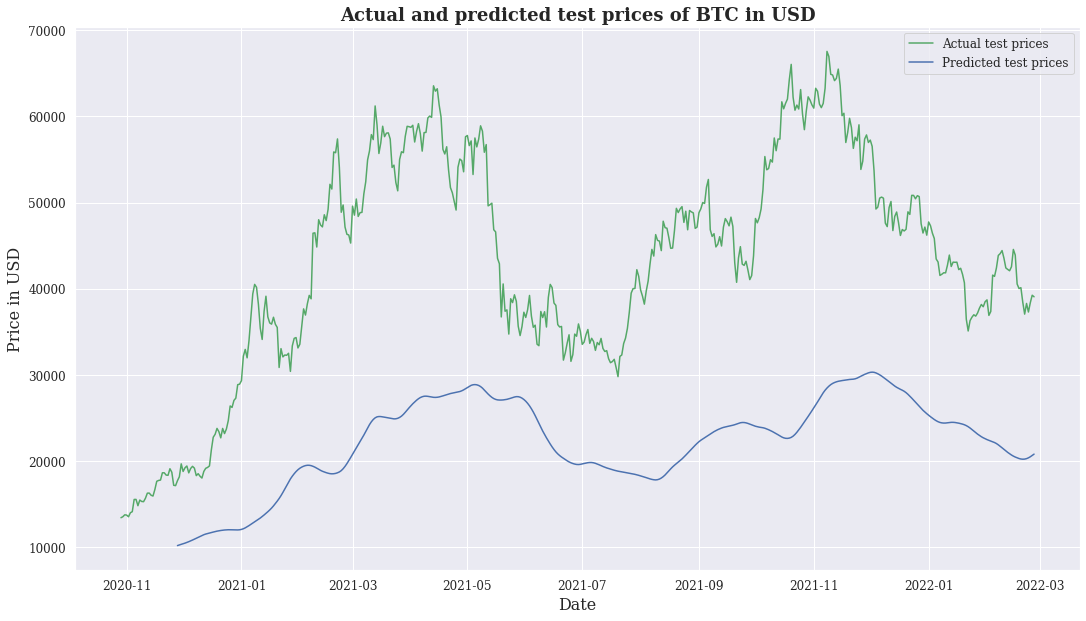

In [118]:
# Predict with test data
BTC_y_pred_test = model.predict(test_generator)
# print(BTC_y_pred_test)

# Inverse transform the data back
BTC_y_pred_test_prices = scaler_y.inverse_transform(BTC_y_pred_test)
print('Actual test data has length', BTC_day_y[index_85pct:].shape)
print('Predicted test data has length', len(BTC_y_pred_test_prices), BTC_y_pred_test_prices.shape)
print('The test MSE is', mean_squared_error(BTC_y_pred_test_prices, BTC_day_y[index_85pct+30:]))

plt.plot(BTC_day_y[index_85pct:].index, BTC_day_y[index_85pct:].values, color = 'g', label = 'Actual test prices')
# Shift index by 30 days forward for predicted prices to get the right dates
plt.plot(BTC_day_y[index_85pct+30:].index, BTC_y_pred_test_prices, color = 'b', label = 'Predicted test prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()
# Track the experiment
# experiment_id = client.create_experiment(EXPERIMENT_NAME)
run = client.create_run(experiment_id)
client.log_metric(run.info.run_id, "mse", mean_squared_error(BTC_y_pred_test_prices, BTC_day_y[index_85pct+30:]))
client.log_metric(run.info.run_id, "mae", mean_absolute_error(BTC_y_pred_test_prices, BTC_day_y[index_85pct+30:]))
client.log_param(run.info.run_id, "model", 'LSTM model with Time Series Generator')
client.log_param(run.info.run_id, "Number of neurons", [128, 64, 32, 32, 0.4, 1])
client.log_param(run.info.run_id, "seq_len", 30)
client.log_param(run.info.run_id, "batch_size", 32)

In [76]:
print(max(BTC_y_pred_test_prices))
print(min(BTC_y_pred_test_prices))

[40107.87]
[11141.192]


In [ ]:
# last_30_days_X_scaled = np.expand_dims(BTC_day_X_scaled[-30:], 0)
# last_30_days_X_scaled.shape

In [ ]:
# next_14_days_y = model.predict(last_30_days_X_scaled)
# next_14_days_y

In [79]:
# Get the last 30 days of X, and it'll predict close of 14 days later
scaled_BTC_day = scaler_X.transform(BTC_day)

seq_X = []
for i in range(14):
  seq_X.append(scaled_BTC_day[-44+i:-14+i])

seq_X = np.array(seq_X)
print(seq_X.shape)

(14, 30, 5)


In [80]:
y_pred = model.predict(seq_X)
y_pred_prices = scaler_y.inverse_transform(y_pred)
days_plot_new_pred = BTC_day_y[-14:].index + timedelta(14)
print(y_pred_prices.shape, y_pred_prices)
print(days_plot_new_pred.shape)
y_pred_df = pd.DataFrame({'pred_price': y_pred_prices.reshape(14,), 'date': days_plot_new_pred})
y_pred_df.set_index('date', inplace=True)
y_pred_df 

(14, 1) [[27227.387]
 [27360.059]
 [27451.523]
 [27560.588]
 [27692.271]
 [27759.68 ]
 [27709.322]
 [27590.307]
 [27410.496]
 [27166.271]
 [26880.096]
 [26606.975]
 [26350.002]
 [26155.121]]
(14,)


,pred_price
date,
2022-02-27,27227.386719
2022-02-28,27360.058594
2022-03-01,27451.523438
2022-03-02,27560.587891
2022-03-03,27692.271484
2022-03-04,27759.679688
2022-03-05,27709.322266
2022-03-06,27590.306641
2022-03-07,27410.496094


DatetimeIndex(['2022-02-27', '2022-02-28', '2022-03-01', '2022-03-02',
               '2022-03-03', '2022-03-04', '2022-03-05', '2022-03-06',
               '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10',
               '2022-03-11', '2022-03-12'],
              dtype='datetime64[ns]', name='time', freq='D')

# Alternate LSTM with hourly data

In [ ]:
# plt.plot(BTC_y_train.index, BTC_y_train, color = 'y', label ='Training prices')
# plt.plot(BTC_y_test.index, BTC_y_test, color = 'y', label ='Test prices')
# plt.plot(BTC_y_test.index, BTC_y_pred, color = 'b', label ='Predicted prices')
# plt.legend()
# plt.show()